In [1]:
import torch
import torchvision
import torchvision.transforms as transforms


In [2]:
! pip install snntorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 2.8 MB/s eta 0:00:00


In [3]:
! pip install pytorch-metric-learning --pre

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 1.5 MB/s eta 0:00:00


In [4]:

! pip install pytorch-metric-learning


In [5]:

from pytorch_metric_learning.losses import NTXentLoss
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.reducers import ThresholdReducer
from pytorch_metric_learning.regularizers import LpRegularizer
from pytorch_metric_learning import losses
from pytorch_metric_learning.losses import SelfSupervisedLoss


In [6]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

<ipython-input-6-a67ec077dde0>:4: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


In [7]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools
import torchvision
#from lightly.loss import NTXentLoss


In [8]:
batch_size = 128


In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     ])

transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  download=True, transform=transform)

train_set_1, train_set_2 = torch.utils.data.random_split(trainset, [40000, 10000])

trainloader_1 = DataLoader(train_set_1, batch_size=batch_size, shuffle=True, drop_last=True)
trainloader_2 = DataLoader(train_set_2, batch_size=batch_size, shuffle=True, drop_last=True)

#trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2 , drop_last=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2 , drop_last=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170498071/170498071 [00:14<00:00, 12157817.83it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
len(testloader)

78

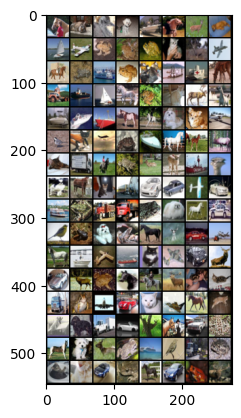

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader_1)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


In [12]:
#dataiter = iter(trainloader_1)
#images, labels = next(dataiter)

In [13]:

#images.shape
#img = images[0]
#img.numpy().shape
#np.transpose(img.numpy(), (1, 2, 0)).shape

Feature batch shape: torch.Size([128, 3, 32, 32])
Labels batch shape: torch.Size([128])


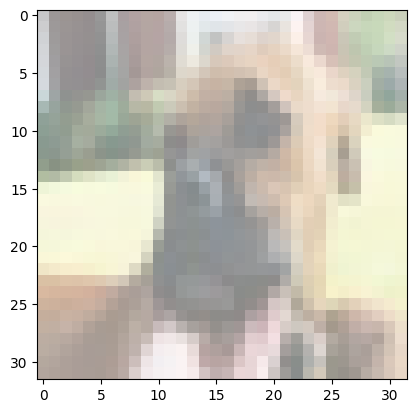

Label: dog


In [14]:
# Display image and label.
train_features, train_labels  = next(iter(trainloader_1))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
img = img / 2 + 0.5
img = np.transpose(img.numpy(), (1, 2, 0))
plt.imshow(img)
plt.show()
print(f"Label: {classes[label]}")

truck
plane
dog
bird
dog
horse
cat
dog
dog


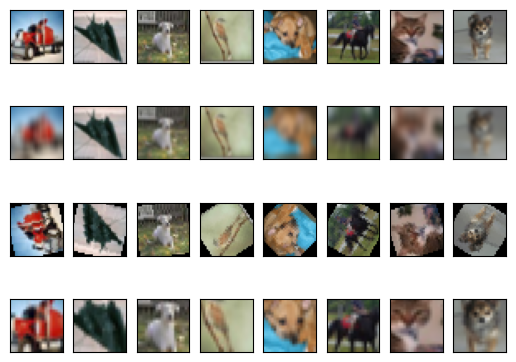

In [15]:
n = 8
fig, ax = plt.subplots(4,n,)
g_transform = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
r_transform = transforms.RandomRotation(degrees=(0, 180))
c_transform = transforms.CenterCrop((20,20))

train_features, train_labels  = next(iter(trainloader_1))

for i, img in enumerate(train_features[:n]):
  #plt.imshow(i.squeeze())
  nimg = img / 2 + 0.5
  nimg = np.transpose(img.numpy(), (1, 2, 0))
  ax[0][i].imshow(nimg)
  ax[1][i].imshow(np.transpose(g_transform(img).numpy(), (1, 2, 0)))
  ax[2][i].imshow(np.transpose(r_transform(img).numpy(), (1, 2, 0)))
  ax[3][i].imshow(np.transpose(c_transform(img).numpy(), (1, 2, 0)))

  print(classes[train_labels[i]])
  for j in range(4):
    ax[j][i].get_xaxis().set_visible(False)
    ax[j][i].get_yaxis().set_visible(False)
print(classes[train_labels[i]],)


In [16]:
# neuron and simulation parameters
#spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.9
num_steps = 10

In [17]:
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [18]:
'''# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.lif1 = snn.Leaky(beta=beta)
        self.conv2 = nn.Conv2d(12, 64, 5)
        self.lif2 = snn.Leaky(beta=beta)
        self.fc1 = nn.Linear(64 * 5 * 5, 32)
        self.lif3 = snn.Leaky(beta=beta)


    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        # Record the final layer
        spk_rec = []
        mem_rec = []
        curr=[]
        for step in range(num_steps):
          cur1 = F.max_pool2d(self.conv1(x), 2)
          #curr.append(cur1)
          spk1, mem1 = self.lif1(cur1, mem1)
          #print(spk1.shape)

          cur2 = F.max_pool2d(self.conv2(spk1), 2)
          spk2, mem2 = self.lif2(cur2, mem2)
          #print(spk2.shape)
          #print(spk2.view(batch_size, -1).shape)
          cur3 = self.fc1(spk2.view(batch_size, -1))
          #print(cur3.shape)
          spk3, mem3 = self.lif3(cur3, mem3)

          spk_rec.append(spk3)
          mem_rec.append(mem3)

        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)
'''



'# Define Network\nclass Net(nn.Module):\n    def __init__(self):\n        super().__init__()\n\n        # Initialize layers\n        self.conv1 = nn.Conv2d(3, 12, 5)\n        self.lif1 = snn.Leaky(beta=beta)\n        self.conv2 = nn.Conv2d(12, 64, 5)\n        self.lif2 = snn.Leaky(beta=beta)\n        self.fc1 = nn.Linear(64 * 5 * 5, 32)\n        self.lif3 = snn.Leaky(beta=beta)\n\n\n    def forward(self, x):\n\n        # Initialize hidden states and outputs at t=0\n        mem1 = self.lif1.init_leaky()\n        mem2 = self.lif2.init_leaky()\n        mem3 = self.lif3.init_leaky()\n\n        # Record the final layer\n        spk_rec = []\n        mem_rec = []\n        curr=[]\n        for step in range(num_steps):\n          cur1 = F.max_pool2d(self.conv1(x), 2)\n          #curr.append(cur1)\n          spk1, mem1 = self.lif1(cur1, mem1)\n          #print(spk1.shape)\n\n          cur2 = F.max_pool2d(self.conv2(spk1), 2)\n          spk2, mem2 = self.lif2(cur2, mem2)\n          #print(spk2

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.conv1 = nn.Conv2d(3, 32,kernel_size=3, padding=1)
        self.lif1 = snn.Leaky(beta=beta)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        self.lif2 = snn.Leaky(beta=beta)

        self.new_conv = nn.Conv2d(64, 128 ,kernel_size=3, padding=1)
        self.lif_new = snn.Leaky(beta=beta)

        self.newnew_conv = nn.Conv2d(128, 256,kernel_size=3, padding=1)
        self.lif_newnew = snn.Leaky(beta=beta)

        self.fc1 = nn.Linear(256 * 1 * 1, 512)  # Adjust input size to match new_conv output
        self.lif3 = snn.Leaky(beta=beta)

        self.fc2 = nn.Linear(512, 32)  # New linear layer added with activation
        self.lif4 = snn.Leaky(beta=beta)  # LIF activation for the new linear layer

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem_new = self.lif_new.init_leaky()
        mem_newnew = self.lif_newnew.init_leaky()

        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()

        spk_rec = []
        mem_rec = []
        curr = []

        for step in range(num_steps):
            cur1 = F.max_pool2d(self.conv1(x), 2)
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = F.max_pool2d(self.conv2(spk1), 2)
            spk2, mem2 = self.lif2(cur2, mem2)

            cur_new = F.max_pool2d(self.new_conv(spk2), 2)
            spk_new, mem_new = self.lif_new(cur_new, mem_new)

            cur_newnew = F.max_pool2d(self.newnew_conv(spk_new), 2)
            spk_newnew, mem_newnew = self.lif_newnew(cur_newnew, mem_newnew)

            cur3 = self.fc1(spk_newnew.view(batch_size, -1))
            spk3, mem3 = self.lif3(cur3, mem3)

            cur4 = self.fc2(spk3.view(batch_size, -1))
            spk4, mem4 = self.lif4(cur4, mem4)  # Pass through the new LIF layer

            spk_rec.append(spk4)
            mem_rec.append(mem4)

        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)


In [20]:
#new version of the network
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.conv1 = nn.Conv2d(3, 32,kernel_size=3, padding=1)
        self.lif1 = snn.Leaky(beta=beta)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.lif2 = snn.Leaky(beta=beta)

        self.conv3 = nn.Conv2d(64, 128 ,kernel_size=3, padding=1)
        self.lif3 = snn.Leaky(beta=beta)

        self.conv4 = nn.Conv2d(128, 128,kernel_size=3, padding=1)
        self.lif4 = snn.Leaky(beta=beta)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.lif5 = snn.Leaky(beta=beta)

        self.conv6 =  nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.lif6 = snn.Leaky(beta=beta)

        self.fc1 = nn.Linear(256*4*4, 1024)  # Adjust input size to match new_conv output
        self.lif7 = snn.Leaky(beta=beta)

        self.fc2 = nn.Linear(1024 , 512)  # New linear layer added with activation
        self.lif8 = snn.Leaky(beta=beta)  # LIF activation for the new linear layer

    def forward(self, x):

        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()
        mem5 = self.lif5.init_leaky()
        mem6 = self.lif6.init_leaky()
        mem7 = self.lif7.init_leaky()
        mem8 = self.lif8.init_leaky()

        spk_rec = []
        mem_rec = []
        curr = []

        for step in range(num_steps):
            cur1 = self.conv1(x)
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = F.max_pool2d(self.conv2(spk1), 2)
            spk2, mem2 = self.lif2(cur2, mem2)

            cur3 = self.conv3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)

            cur4 = F.max_pool2d(self.conv4(spk3) , 2)
            spk4, mem4 = self.lif4(cur4, mem4)

            cur5 = self.conv5(spk4)
            spk5, mem5 = self.lif5(cur5, mem5)

            cur6 = F.max_pool2d(self.conv6(spk5) , 2)
            spk6, mem6 = self.lif4(cur6, mem6)

            #spk6 = nn.Flatten(spk6)
            cur7 = self.fc1(spk6.view(batch_size, -1))
            spk7, mem7 = self.lif7(cur7, mem7)

            cur8 = self.fc2(spk7.view(batch_size, -1))
            spk8, mem8 = self.lif8(cur8, mem8)  # Pass through the new LIF layer

            spk_rec.append(spk8)
            mem_rec.append(mem8)

        return torch.stack(spk_rec, dim=0), torch.stack(mem_rec, dim=0)


In [21]:

net = Net().to(device)

In [22]:
from torchvision import models
from torchsummary import summary

In [49]:
net

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lif1): Leaky()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lif2): Leaky()
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lif3): Leaky()
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lif4): Leaky()
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lif5): Leaky()
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lif6): Leaky()
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (lif7): Leaky()
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (lif8): Leaky()
)

In [44]:
print(net.summary())

AttributeError: ignored

In [23]:
data, targets = next(iter(trainloader_1))
data = data.to(device)
targets = targets.to(device)

spk_out, mem_out  = net(data)
spk_out.shape

torch.Size([10, 128, 512])

In [24]:
#torch.stack(currr, dim=0).shape

In [25]:
!pip install torchviz


  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=3301f2cd480f8d1b35e9c23f5a7e64077bf9aaeaa432dc23e280e2dbb6908938
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [27]:
from torchviz import make_dot

make_dot(spk_out.mean(), params=dict(net.parameters()))


ValueError: ignored

In [37]:
!pip install hiddenlayer


In [ ]:
net



Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lif1): Leaky()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lif2): Leaky()
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lif3): Leaky()
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lif4): Leaky()
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lif5): Leaky()
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lif6): Leaky()
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (lif7): Leaky()
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (lif8): Leaky()
)

In [ ]:
#loss

loss_func_self_trip = SelfSupervisedLoss(losses.TripletMarginLoss(distance = CosineSimilarity(),
                                        reducer = ThresholdReducer(high=0.3), embedding_regularizer = LpRegularizer()))
loss_func_NTX = NTXentLoss()
loss_func_self_NTX =  SelfSupervisedLoss(NTXentLoss())
loss_func_triplet = losses.TripletMarginLoss(distance = CosineSimilarity(),
                                    reducer = ThresholdReducer(high=0.3),
                                    embedding_regularizer = LpRegularizer())

loss_func_self_con = SelfSupervisedLoss(losses.ContrastiveLoss(pos_margin=0, neg_margin=1))

In [ ]:
loss_func_self_ang = SelfSupervisedLoss(losses.AngularLoss(alpha=40))
loss_func_self_cir = SelfSupervisedLoss(losses.CircleLoss(m=0.4, gamma=80))
loss_func_self_pair = SelfSupervisedLoss(losses.IntraPairVarianceLoss(pos_eps=0.01, neg_eps=0.01, ))


In [ ]:

#optimizer

optimizer = torch.optim.Adam(net.parameters(), lr=1e-5, betas=(0.9, 0.999))


In [ ]:

num_epochs = 3
loss_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    print(epoch)
    # Training loop
    for i , (data, targets) in enumerate(iter(trainloader_1)):
        data = data.to(device)
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()

        data_r = r_transform(data)
        data_g = g_transform(data)

        spk_rec_r, mem_rec_r = net(data_r)
        spk_rec_g, mem_rec_g = net(data_g)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)

        for step in range(num_steps):
            loss_val += loss_func_self_NTX(mem_rec_r[step], mem_rec_g[step])

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        if i%100 == 0 :
          print(i)



0


OutOfMemoryError: ignored

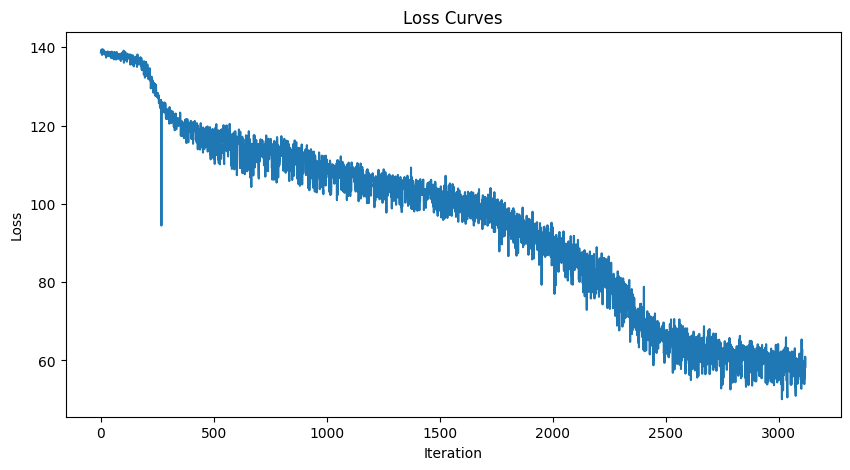

In [ ]:
  # Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.title("Loss Curves")
plt.xlabel("Iteration")
plt.ylabel("Loss")


plt.show()

In [ ]:
l =[]
ll=[]
for test_data, test_targets in iter(testloader):
      test_data = test_data.to(device)
      test_targets = test_targets.to(device)
      l.append(test_data.detach().cpu().numpy())
      ll.append(test_targets.detach().cpu().numpy())


In [ ]:
ll=np.array(ll)
ll = ll.reshape(78*128)
l=np.array(l)
l = l.reshape((78*128, 3, 32, 32))


In [ ]:
net.eval()
embeddings = []

with torch.no_grad():

            for test_data, test_targets in iter(testloader):
              test_data = test_data.to(device)
              test_targets = test_targets.to(device)
              # Test set forward pass
              spk_out , mem_out = net(test_data)
              embeddings.append(mem_out.sum(dim=0).detach().cpu().numpy())
            embeddings = np.array(embeddings)
            embeddings = embeddings.reshape((78*128, 32))

In [ ]:
'''with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(trainloader_1))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data)'''


'with torch.no_grad():\n            net.eval()\n            test_data, test_targets = next(iter(trainloader_1))\n            test_data = test_data.to(device)\n            test_targets = test_targets.to(device)\n\n            # Test set forward pass\n            test_spk, test_mem = net(test_data)'

In [ ]:
embeddings.shape

(9984, 32)

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize


In [ ]:
n_neighbors=10

num_examples=4

In [ ]:

X = embeddings

#X = test_mem.sum(dim=0).detach().numpy()
nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X)

distances, indices = nbrs.kneighbors(X)

samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)


In [ ]:
samples_idx
#4138 , 3396 5638, 7431

array([ 534, 7937, 1858, 7901])

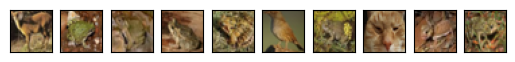

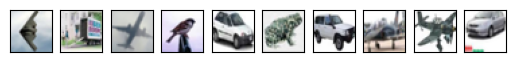

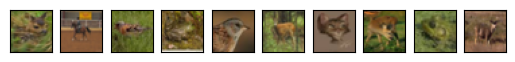

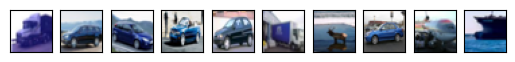

In [ ]:
for i in range(len(samples_idx)):
    fig, ax = plt.subplots(1 , n_neighbors)
    #ax[0].imshow(np.transpose(test_data[samples_idx[i]].numpy(), (1, 2, 0)))
    #ax[0].set_title(classes[test_targets[samples_idx[i]]])
    for j , k in enumerate(indices[samples_idx[i]]):
      ax[j].imshow(np.transpose(l[k], (1, 2, 0)))
      ax[j].get_xaxis().set_visible(False)
      ax[j].get_yaxis().set_visible(False)
      #ax[j].set_title(classes[ll[k]])

In [ ]:
'''for i in range(len(samples_idx)):
    fig, ax = plt.subplots(1 , n_neighbors)
    #ax[0].imshow(np.transpose(test_data[samples_idx[i]].numpy(), (1, 2, 0)))
    #ax[0].set_title(classes[test_targets[samples_idx[i]]])
    for j , k in enumerate(indices[samples_idx[i]]):
      ax[j].imshow(np.transpose(test_data[k].numpy(), (1, 2, 0)))
      ax[j].set_title(classes[test_targets[k]])
'''

'for i in range(len(samples_idx)):\n    fig, ax = plt.subplots(1 , n_neighbors)\n    #ax[0].imshow(np.transpose(test_data[samples_idx[i]].numpy(), (1, 2, 0)))\n    #ax[0].set_title(classes[test_targets[samples_idx[i]]])\n    for j , k in enumerate(indices[samples_idx[i]]):\n      ax[j].imshow(np.transpose(test_data[k].numpy(), (1, 2, 0)))\n      ax[j].set_title(classes[test_targets[k]])\n'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler



In [ ]:
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt


In [ ]:
#Define Network

class Classifier(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        # use the pretrained ResNet backbone
        self.backbone = backbone

        # freeze the backbone
        #for param in backbone.parameters():
           #param.requires_grad = False

        # create a linear layer for our downstream classification model
        self.fc = nn.Linear(32, 10)


    def forward(self, x):
        spk , mem = self.backbone(x)
        y_hat = self.fc(spk)
        return y_hat

# Load the network onto CUDA if available
classifier = Classifier(net).to(device)

In [ ]:
classifier

Classifier(
  (backbone): Net(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (lif1): Leaky()
    (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
    (lif2): Leaky()
    (new_conv): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
    (lif_new): Leaky()
    (newnew_conv): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
    (lif_newnew): Leaky()
    (fc1): Linear(in_features=256, out_features=512, bias=True)
    (lif3): Leaky()
    (fc2): Linear(in_features=512, out_features=32, bias=True)
    (lif4): Leaky()
  )
  (fc): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
'''data, targets = next(iter(trainloader_1))
data = data.to(device)
targets = targets.to(device)

spk_out, mem_out  = net(data)
spk_out.shape'''

'data, targets = next(iter(trainloader_1))\ndata = data.to(device)\ntargets = targets.to(device)\n\nspk_out, mem_out  = net(data)\nspk_out.shape'

In [ ]:
# already imported snntorch.functional as SF
loss_fn = SF.ce_rate_loss()

In [ ]:
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec = net(data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [ ]:
mse_loss = nn.MSELoss()
cosine_loss = torch.nn.CosineSimilarity(dim=0)
cross_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-5, betas=(0.9, 0.999))


In [ ]:
num_epochs = 100
loss_hist = []
test_loss_hist = []
test_acc_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):
    print(epoch)
    iter_counter = 0
    train_batch = iter(trainloader_2)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        classifier.train()
        spk_rec = classifier(data)

        #loss_val = mse_loss(spk_rec, targets)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += cross_loss(spk_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            classifier.eval()
            test_data, test_targets = next(iter(testloader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk = classifier(test_data)

            # Test set loss
            #test_loss = cross_loss(test_spk, test_targets)
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += cross_loss(test_spk[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Test set
            if counter % 50 == 0:
              with torch.no_grad():
                net.eval()


                # Test set forward pass
                test_acc = batch_accuracy(testloader, classifier, num_steps)
                #print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
                test_acc_hist.append(test_acc.item())

            counter += 1


            '''# Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer()
            counter += 1
            iter_counter +=1'''

0
1
2
3


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f2a93043910>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


KeyboardInterrupt: ignored

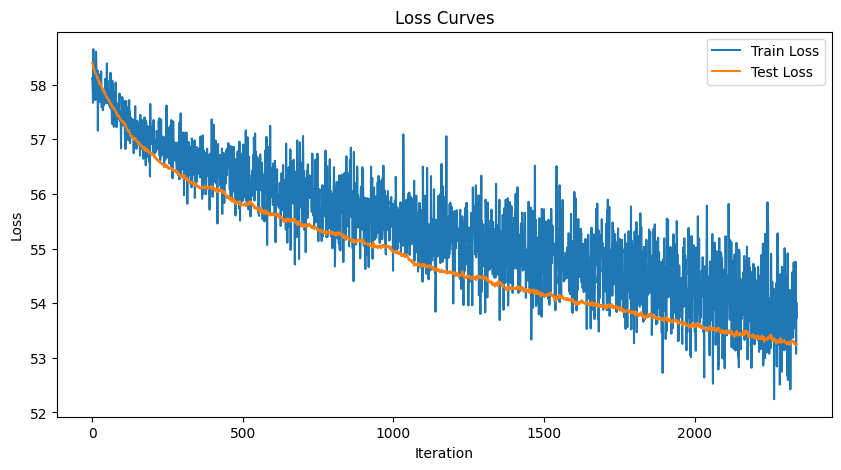

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:

test_acc_hist

[0.10016025641025642,
 0.10997596153846154,
 0.11478365384615384,
 0.15825320512820512,
 0.1837940705128205,
 0.18559695512820512,
 0.1867988782051282,
 0.18659855769230768,
 0.18840144230769232,
 0.19080528846153846,
 0.19170673076923078,
 0.19541266025641027,
 0.19381009615384615,
 0.19921875,
 0.19921875,
 0.20552884615384615,
 0.20352564102564102,
 0.203125,
 0.20833333333333334,
 0.21003605769230768,
 0.20983573717948717,
 0.20592948717948717,
 0.20703125,
 0.21173878205128205,
 0.21223958333333334,
 0.21384214743589744,
 0.2132411858974359,
 0.21284054487179488,
 0.2155448717948718,
 0.21564503205128205,
 0.21764823717948717,
 0.21905048076923078,
 0.22155448717948717,
 0.2194511217948718,
 0.22225560897435898,
 0.22536057692307693,
 0.22275641025641027,
 0.22365785256410256,
 0.22455929487179488,
 0.2270633012820513,
 0.22786458333333334,
 0.2327724358974359,
 0.2297676282051282,
 0.23197115384615385,
 0.23137019230769232,
 0.23287259615384615,
 0.23157051282051283]

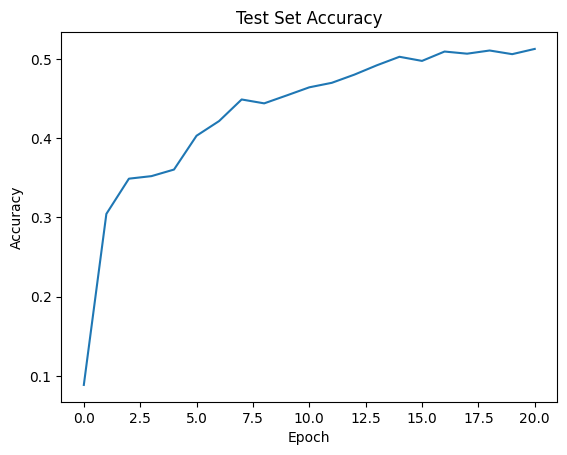

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
test_pred=test_spk.sum(dim=0).max(1)[1]


In [ ]:
test_spk.shape

torch.Size([20, 128, 10])

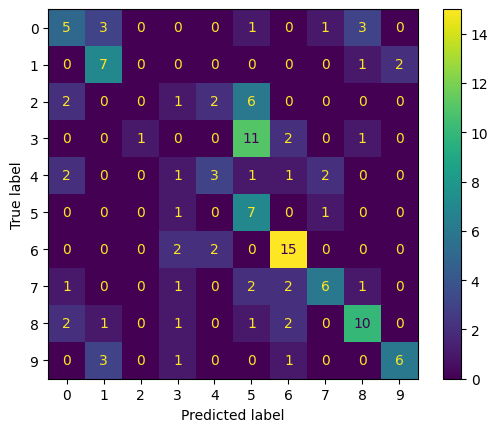

In [ ]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(test_targets.cpu(), test_pred.cpu())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()

In [ ]:
acc = np.mean((test_targets == test_pred).detach().cpu().numpy())
print(acc)

0.4609375


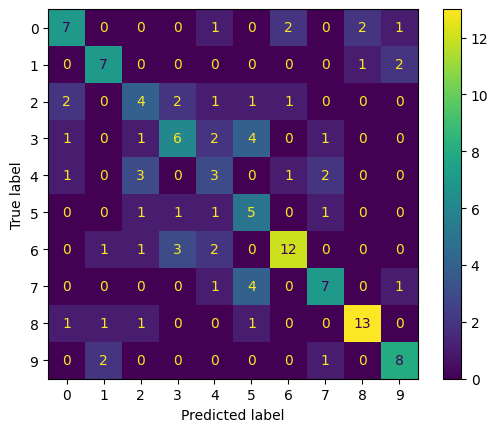

In [ ]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(test_targets.cpu(), test_pred.cpu())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.show()


In [ ]:
acc = np.mean((test_targets == test_pred).detach().cpu().numpy())
print(acc)

0.5625
